# LangGraph - Calling Tools

* [Deeplearning.ai - AI Agents in LangGraph](https://learn.deeplearning.ai/courses/ai-agents-in-langgraph/lesson/l7rgk/langgraph-components)
* [Tavily](https://app.tavily.com/home) - Get API Key here
* [langchain-tavily](https://docs.langchain.com/oss/python/integrations/providers/tavily)

In [1]:
!pip install -U langchain-tavily --quiet


[notice] A new release of pip is available: 24.0 -> 25.3
[notice] To update, run: pip install --upgrade pip


In [2]:
import json
import logging
import os
import operator
import sys
from typing import (
    Annotated, List, Dict, TypedDict, Callable, Union
)
import operator

from langchain_core.messages import BaseMessage, SystemMessage, ToolMessage
from langgraph.graph import END, StateGraph, START

import openai
from langgraph.graph import StateGraph, START, END
from langchain_core.messages import AnyMessage, SystemMessage, HumanMessage, ToolMessage
from langchain.chat_models import init_chat_model
from langchain_community.tools.tavily_search import TavilySearchResults

from IPython.display import Image, display

In [3]:
# logging.basicConfig(stream=sys.stdout, level=logging.INFO)
# logger = logging.getLogger('LOGGER_NAME')

# API Keys

In [4]:
path_to_openai_key:str = os.path.expanduser('~/.openai/api_key')
with open(path_to_openai_key, 'r', encoding='utf-8') as file:
    os.environ["OPENAI_API_KEY"] = file.read().strip()

path_to_tavily_key:str = os.path.expanduser('~/.tavily/api_key')
with open(path_to_tavily_key, 'r', encoding='utf-8') as file:
    os.environ["TAVILY_API_KEY"] = file.read().strip()

# Model

In [5]:
MODEL: str = 'gpt-4.1'

model = init_chat_model(f"openai:{MODEL}")

# Tools

In [6]:
search = TavilySearchResults(max_results=4)

/var/folders/_4/8v285hqs45xfzk0l1nlr3yq40000gn/T/ipykernel_46279/2774767458.py:1: LangChainDeprecationWarning: The class `TavilySearchResults` was deprecated in LangChain 0.3.25 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-tavily package and should be used instead. To use it run `pip install -U :class:`~langchain-tavily` and import as `from :class:`~langchain_tavily import TavilySearch``.
  search = TavilySearchResults(max_results=4)


# LLM Prompt

In [7]:
system_prompt = """You are a smart research assistant. Use the search engine to look up information. \
You are allowed to make multiple calls (either together or in sequence). \
Only look up information when you are sure of what you want. \
If you need to look up some information before asking a follow up question, you are allowed to do that!
"""

# LangGraph Application

In [8]:
class AgentState(TypedDict):
    """The state of the agent passed between nodes.

    Attributes:
        messages: A list of messages in the conversation, using operator.add
            to append new messages to the existing history.
    """
    messages: Annotated[List[AnyMessage], operator.add]


class Agent:
    """An agent that coordinates between an LLM and a set of tools."""

    def __init__(
        self,
        model,
        tools: List[Callable],
        system_prompt: str = ""
    ):
        """Initializes the agent with a model, tools, and an optional system prompt.

        Args:
            model: The LLM model instance (e.g., ChatOpenAI).
            tools: A list of tool functions the agent can invoke.
            system_prompt: An optional string to set the agent's behavior.
        """
        self.system_prompt = system_prompt
        self.tools = {t.name: t for t in tools}

        # model.bind_tools(tools) performs three main tasks: 
        # Schema Conversion: converts tool (python function) into the JSON schema format that LLM provider expects.
        # API Integration: attaches these schemas to the model object.
        # Instructional Hinting: tells the LLM that for a question that requires a tool, return a 'tool call' with arguments.
        self.model = model.bind_tools(tools)

        # Build Graph
        builder = StateGraph(AgentState)
        builder.add_node("llm", self.call_llm)
        builder.add_node("action", self.take_action)

        builder.add_edge(START, "llm")

        builder.add_conditional_edges(
            "llm",
            self.exists_action,
            {True: "action", False: END}
        )

        builder.add_edge("action", "llm")

        self.graph = builder.compile()

    def exists_action(self, state: AgentState) -> bool:
        """Determines if the LLM has requested a tool call.
        Args:
            state: The current graph state.

        Returns:
            True if tool calls are present, False otherwise.
        """
        last_message = state["messages"][-1]
        return len(getattr(last_message, "tool_calls", [])) > 0

    def call_llm(self, state: AgentState) -> Dict[str, List[BaseMessage]]:
        """Invokes the LLM with the current message history.
        Args:
            state: The current graph state.

        Returns:
            A dictionary updating the 'messages' key with the LLM's response.
        """
        messages = state["messages"]
        
        # Add system prompt to the start of the conversation if it exists
        if self.system_prompt and not any(isinstance(m, SystemMessage) for m in messages):
            messages = [SystemMessage(content=self.system_prompt)] + messages
            
        response = self.model.invoke(messages)
        return {"messages": [response]}

    def take_action(self, state: AgentState) -> Dict[str, List[ToolMessage]]:
        """Executes the tool calls requested by the LLM.

        Args:
            state: The current graph state.

        Returns:
            A dictionary containing the ToolMessages with results.
        """
        last_message = state["messages"][-1]
        tool_calls = getattr(last_message, "tool_calls", [])
        results = []

        for t in tool_calls:
            print(f"Calling tool: {t['name']}")
            if t["name"] not in self.tools:
                print("\nbad tool name:[%s]", t["name"])
                result = f"Error: {t['name']} is not a valid tool. Please retry."
            else:
                result = self.tools[t["name"]].invoke(t["args"])

            results.append(
                ToolMessage(
                    tool_call_id=t["id"],
                    name=t["name"],
                    content=str(result)
                )
            )

        print("Action complete. Returning to model.")
        return {"messages": results}

    def __call__(self, queries: List[str]):
        return self.graph.invoke(AgentState(messages=[HumanMessage(content=query) for query in queries]))

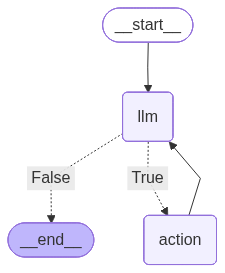

In [9]:
app = Agent(model=model, tools=[search], system_prompt=system_prompt)
try:
    display(Image(app.graph.get_graph().draw_mermaid_png()))
except Exception as e:
    print(e)

# Execution

In [14]:
responses = app(["Current weather in New York", "Is it raining Sydney now?"])

Calling tool: tavily_search_results_json
Calling tool: tavily_search_results_json
Action complete. Returning to model.


In [15]:
print(json.dumps(responses, indent=4, default=str, ensure_ascii=False))

{
    "messages": [
        "content='Current weather in New York' additional_kwargs={} response_metadata={}",
        "content='Is it raining Sydney now?' additional_kwargs={} response_metadata={}",
        "content='' additional_kwargs={'tool_calls': [{'id': 'call_9Xlv85GKsvkwsqcv62xpYZs9', 'function': {'arguments': '{\"query\": \"current weather in New York\"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}, {'id': 'call_Zl6k0D1z8KDbL0CdC5qJVNpM', 'function': {'arguments': '{\"query\": \"is it raining in Sydney now\"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}], 'refusal': None} response_metadata={'token_usage': {'completion_tokens': 61, 'prompt_tokens': 159, 'total_tokens': 220, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4.1-2025-04-14', 'system_fingerprint': 'fp_92419d3fe

In [16]:
for index, answer in enumerate(responses['messages']):
    print(f"[message:{index:02}] " + '-' * 80)
    print(answer.content + '\n')


[message:00] --------------------------------------------------------------------------------
Current weather in New York

[message:01] --------------------------------------------------------------------------------
Is it raining Sydney now?

[message:02] --------------------------------------------------------------------------------


[message:03] --------------------------------------------------------------------------------
[{'title': 'Weather in New York City in December 2025', 'url': 'https://world-weather.info/forecast/usa/new_york/december-2025/', 'content': 'Sunday, 21 December. Day. +43°. 9.6. 30. 38%. +37°. 07:16 AM. 04:32 PM. Waxing ... Average daytime values for December 2025. Extended weather forecast in New York', 'score': 0.9996724}, {'title': 'New York weather in December 2025 - Weather25.com', 'url': 'https://www.weather25.com/north-america/usa/new-york?page=month&month=December', 'content': 'You can expect a few days of snow in New York during December. It’s import

# Pretty Print

In [17]:
import ast
from IPython.display import display, Markdown

raw_data = responses['messages'][-2].content
data = ast.literal_eval(raw_data)

# 2. Build the Markdown Table
table_md = "| Score | Title | URL |\n| :--- | :--- | :--- |\n"

for entry in data:
    # We truncate the title if it's too long and format the link
    short_title = (entry['title'][:75] + '..') if len(entry['title']) > 75 else entry['title']
    link = f"[{short_title}]({entry['url']})"
    score = f"{entry['score']:.2f}" # Format score to 2 decimal places
    
    table_md += f"| {score} | {link} | [Link]({entry['url']}) |\n"

# 3. Render
display(Markdown("## Search Results Summary"))
display(Markdown(table_md))

# 4. Optional: Display detailed content in collapsible sections
display(Markdown("---"))
display(Markdown("### Detailed Source Content"))
for i, entry in enumerate(data):
    detail_md = f"""
<details>
  <summary><b>Source {i+1}: {entry['title']}</b></summary>
  
  {entry['content']}
  
</details>
"""
    display(Markdown(detail_md))

## Search Results Summary

| Score | Title | URL |
| :--- | :--- | :--- |
| 0.97 | [Sydney, New South Wales, Australia Weather Forecast](https://www.accuweather.com/en/au/sydney/22889/weather-forecast/22889) | [Link](https://www.accuweather.com/en/au/sydney/22889/weather-forecast/22889) |
| 0.96 | [Sydney, New South Wales | The Bureau of Meteorology](https://www.bom.gov.au/location/australia/new-south-wales/metropolitan/bnsw_pt131-sydney) | [Link](https://www.bom.gov.au/location/australia/new-south-wales/metropolitan/bnsw_pt131-sydney) |
| 0.19 | [Weather Forecast and Conditions for Sydney, New South Wales ...](https://weather.com/weather/today/l/98ef17e6662508c0af6d8bd04adacecde842fb533434fcd2c046730675fba371) | [Link](https://weather.com/weather/today/l/98ef17e6662508c0af6d8bd04adacecde842fb533434fcd2c046730675fba371) |
| 0.11 | [Sydney - BBC Weather](https://www.bbc.com/weather/2147714) | [Link](https://www.bbc.com/weather/2147714) |


---

### Detailed Source Content


<details>
  <summary><b>Source 1: Sydney, New South Wales, Australia Weather Forecast</b></summary>
  
  Tomorrow: Not as hot with times of clouds and sun; humid in the morning, becoming breezy in the afternoon
Hi: 84°

## Current Weather

9:02 PM

### MINUTECAST™

Rain will continue for 48 min

## Looking Ahead

Expect showery weather Wednesday evening through Thursday morning

## Sydney Weather Radar

Sydney Weather Radar

## Hourly Weather

rain drop

rain drop

rain drop

rain drop

rain drop

rain drop

rain drop

rain drop

rain drop

rain drop

rain drop

rain drop [...] Largest wildlife overpass in North America opens across 6-lane highway

1 day ago

Weather Forecasts

Heavy rain, flooding to focus on California leading up to Christmas

23 minutes ago

Winter Weather

What are the snowiest cities in the US?

1 day ago

Featured Stories

Weather News

 Los Angeles wildfires linked to spike in heart, lung emergencies

1 day ago

Astronomy

Satellite ‘Crash Clock’ shows orbit 2.8 days from potential disaster

3 days ago

Weather News [...] ## 10-Day Weather Forecast

Tonight

12/21

Clouds breaking; warm

Mon

12/22

Not as hot, turning breezy

Night: Breezy early; cloudy

Tue

12/23

Sunshine; windy in the p.m.

Breezy early; partly cloudy

Wed

12/24

Warm; windy in the afternoon

Showers late

Thu

12/25

Occasional morning rain

Mostly cloudy and windy

Fri

12/26

Lots of sun; breezy, nice

Partly cloudy

Sat

12/27

Sunshine

Clear

Sun

12/28

Mostly sunny

Clear

Mon

12/29

Plenty of sun

Clear

Tue

12/30
  
</details>



<details>
  <summary><b>Source 2: Sydney, New South Wales | The Bureau of Meteorology</b></summary>
  
  Sunny. No rain. Rain radar and weather map. Show more about today. Hourly forecast. Text only table. Temperature and rain. Wind. Humidity, UV and cloud. Show ...Read more
  
</details>



<details>
  <summary><b>Source 3: Weather Forecast and Conditions for Sydney, New South Wales ...</b></summary>
  
  Home

Home

Today

Today

Hourly

Hourly

10 Day

10 Day

Monthly

Monthly

Radar

Radar

Video

Video

Explore

Explore

Home

Home

Today

Today

Hourly

Hourly

10 Day

10 Day

Monthly

Monthly

Radar

Radar

Video

Video

Explore

Explore

Wind

Humidity

Air Quality

Dew Point

Pressure

UV Index

Visibility

Moon Phase

Sunrise

Sunset

## Hourly Weather

## Don't Miss

## Here's Where You Could Run Into Christmas Travel Problems [...] 1:21

## Hundreds Of Santas Go Skiing For A Good Cause

0:34

## Climate Change Is Threatening Your Favorite Holiday Flavors

1:54

## The Weather Tricks Behind Your Favorite Holiday Movies

2:54

## What Makes A Christmas Movie? Hint: It's The Weather

1:21

## Hundreds Of Santas Go Skiing For A Good Cause

0:34

## Climate Change Is Threatening Your Favorite Holiday Flavors

1:54

## The Weather Tricks Behind Your Favorite Holiday Movies

2:54

# Daily Forecast

## Travel [...] ## We Love Our Critters

## Pet Parrot In Florida Can’t Get Enough Of The Rain

0:22

## Leopards Frolic In The Chicago Snow

0:26

## Watch: Cat Has Adorable Encounter With Snow Twin

0:21

## Watch: Tiny Kitten Rescued As First Snow Hits New York

0:23

## Pet Parrot In Florida Can’t Get Enough Of The Rain

0:22

## Leopards Frolic In The Chicago Snow

0:26

## Watch: Cat Has Adorable Encounter With Snow Twin

0:21

## Watch: Tiny Kitten Rescued As First Snow Hits New York

0:23
  
</details>



<details>
  <summary><b>Source 4: Sydney - BBC Weather</b></summary>
  
  ## Accessibility links

## Search for a location

# Sydney - Weather warnings issued

## Forecast - Sydney

### Day by day forecast

### Environmental Summary

### Sunrise Sunset

### Sunrise Sunset

### Sunrise Sunset

### Sunrise Sunset

### Sunrise Sunset

### Sunrise Sunset

### Sunrise Sunset

### Sunrise Sunset

### Sunrise Sunset

### Sunrise Sunset

### Sunrise Sunset

### Sunrise Sunset

### Sunrise Sunset

### Sunrise Sunset

### Hour by hour forecast

### Environmental Summary [...] ## Observations for SydneyObservations

## Settings

## More Weather

### UK

### About BBC Weather

### Elsewhere

BBC Weather in association with MeteoGroup, external

All times are Australian Eastern Daylight Time (Australia/Sydney, GMT+11) unless otherwise stated.

## Explore the BBC [...] ### Sunrise Sunset

### Sunrise Sunset

### Sunrise Sunset

### Sunrise Sunset

### Sunrise Sunset

### Sunrise Sunset

### Sunrise Sunset

### Sunrise Sunset

### Sunrise Sunset

### Sunrise Sunset

### Sunrise Sunset

### Sunrise Sunset

### Sunrise Sunset

### Sunrise Sunset

## Outlook forecast map

## Forecast for Australasia

### Latest forecast for Australasia

## To play this video you need to enable JavaScript in your browser.

This video can not be played
  
</details>
